In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
import networkx as nx

## Import data 

In [2]:
# import data which has been processed and filtered out self-loop interaction
high_data = os.path.join('high_self_loop_filter_data.csv')
low_data = os.path.join('low_self_loop_filter_data.csv')
physical_data = os.path.join('physical_self_loop_filter_data.csv') 

In [3]:
high_df = pd.read_csv(high_data)
low_df = pd.read_csv(low_data)
physical_df = pd.read_csv(physical_data)


In [4]:
len(physical_df)

958249

In [5]:
physical_df.head()

,Official Symbol Interactor A,Official Symbol Interactor B,Throughput,Experimental System Type,Experimental System,Publication Source
0,MAP2K4,FLNC,Low Throughput,physical,Two-hybrid,PUBMED:9006895
1,MYPN,ACTN2,Low Throughput,physical,Two-hybrid,PUBMED:11309420
2,ACVR1,FNTA,Low Throughput,physical,Two-hybrid,PUBMED:8599089
3,GATA2,PML,Low Throughput,physical,Two-hybrid,PUBMED:10938104
4,RPA2,STAT3,Low Throughput,physical,Two-hybrid,PUBMED:10875894


## Basic network analysis 

### Write function to generate basic information of three networks 

#### Generate the elements for network analysis
Total number of the nodes is equal to the number of elements or different interactor within this ppi network 

In [14]:
# this function will turn the col of interactor A and B into two different Series and merge them together to count the number of unique elements
def count_node(df):
    Col_Interactor_A = df['Official Symbol Interactor A']
    Col_Interactor_B = df['Official Symbol Interactor B']
    temp_concat = pd.concat([Col_Interactor_A, Col_Interactor_B])
    num_node = temp_concat.nunique()
    #print('Number of nodes:\n')
    return num_node
    

In [32]:
# Define the function to count number of different pulications
def count_publication(df):
    temp_concat = df['Publication Source']
    num_pub = temp_concat.nunique()
    return num_pub

In [37]:
# Define the function to count number of interactions which means edges
# Found there are some duplicates of same pairs of protein interactions generated from different experimental system.
# For further analysis, we need to collapse the pairs and drop these duplicate
def drop_duplicate(df):
    drop_dup_df = pd.DataFrame()
    temp_concat = df[['Official Symbol Interactor A','Official Symbol Interactor B']]
    drop_dup_df = df.drop_duplicates()
    #num_edge = len(drop_dup_df)
    return drop_dup_df

In [38]:
# not considering self-loop
# filter the self interaction data
def filter_self_loop(df):
    df2 = df.copy()
    for idx, row in df.iterrows():
        InteractorA = row['Official Symbol Interactor A']
        InteractorB = row['Official Symbol Interactor B']
        if InteractorA == InteractorB:
            print('Found self-loop')
            print(idx)
            df2 = df2.drop(idx)
    return df2
        

#### Run function


In [39]:
# drop duplicate first
low_df2 = drop_duplicate(low_df)
high_df2 = drop_duplicate(high_df)
phy_df2 = drop_duplicate(physical_df)

In [40]:
# low throughput network
#low_num_node = count_node(low_df2)
low_num_pub = count_publication(low_df2)

In [45]:
# high throughput network
#high_num_node = count_node(high_df2)
high_num_pub = count_publication(high_df2)

In [46]:
# all physical interaction  network
#phy_num_node = count_node(phy_df2)
phy_num_pub = count_publication(phy_df2)

## Convert dataframe to adjacency matrix
According to the protein interaction data, it is undirected graph and shows binary data

In [70]:
# generate directed graph based on the column of interaction A and B
G_low = nx.from_pandas_edgelist(low_df2, 
                                'Official Symbol Interactor A', 
                                'Official Symbol Interactor B')

In [71]:
G_high = nx.from_pandas_edgelist(high_df2, 
                                 'Official Symbol Interactor A', 
                                 'Official Symbol Interactor B')

In [72]:
G_phy = nx.from_pandas_edgelist(phy_df2, 
                                 'Official Symbol Interactor A', 
                                 'Official Symbol Interactor B')

### Count edge & node 

In [73]:
G_low_edge = G_low.number_of_edges()
G_low_node = G_low.number_of_nodes()

In [74]:
G_high_edge = G_high.number_of_edges()
G_high_node = G_high.number_of_nodes()

In [75]:
G_phy_edge = G_phy.number_of_edges()
G_phy_node = G_phy.number_of_nodes()

### Count connected components 

In [79]:
G_low_CC = nx.number_connected_components(G_low)
G_high_CC = nx.number_connected_components(G_high)
G_phy_CC = nx.number_connected_components(G_phy)

### Network density 

In [80]:
G_low_density = nx.density(G_low)
G_high_density = nx.density(G_high)
G_phy_density = nx.density(G_phy)

In [81]:
G_low_density

0.0008521973549742003

### Average degree 

In [95]:
# Average degree for undirected graph should be the sum of degrees / total nodes
def avg_degree(G):
    degree_list = [val for (node, val) in G.degree()]
    total_degree = sum(degree_list)
    avg_degree = total_degree / len(degree_list)
    return avg_degree
    

In [98]:
G_low_avg_degree = avg_degree(G_low)
G_high_avg_degree = avg_degree(G_high)
G_phy_avg_degree = avg_degree(G_phy)

In [97]:
G_low_avg_degree

12.505996184246388

### Generate highest degree 

In [115]:
def generate_highest_degree(G):
    sort_degreelist = sorted(G.degree, key=lambda x: x[1], reverse=True)
    highest_degree = sort_degreelist[0]
    protein = highest_degree[0]
    protein_degree = highest_degree[1]
    combined_data = protein + ':' + str(protein_degree)
                                    
    return combined_data
    

In [117]:
G_low_highest_degree = generate_highest_degree(G_low)
G_high_highest_degree = generate_highest_degree(G_high)
G_phy_highest_degree = generate_highest_degree(G_phy)

### Generate highest clustering cofficient

In [163]:
from collections import Counter
def generate_highest_clucoff(G):
    clucoff = nx.clustering(G)
    degrees = {node:val for (node, val) in G.degree()}
    c = Counter(clucoff)
    top100 = c.most_common(100)
    #count = 0
    for protein, clucoff_value in top100:
        if degrees[protein] >= 3:
            sample = protein + ':' + str(clucoff_value)
        else:
            #count += 1
            #print(count)
            continue
            
    return sample
            

In [164]:
G_low_clucoff = generate_highest_clucoff(G_low)
G_high_clucoff = generate_highest_clucoff(G_high)
G_phy_clucoff = generate_highest_clucoff(G_phy)

In [165]:
G_low_clucoff

'PI3:1.0'

## Generate table for the networks 

In [166]:
low_col = [G_low_node,G_low_edge,low_num_pub, G_low_CC, 
           G_low_density,G_low_avg_degree,G_low_highest_degree,G_low_clucoff]

In [168]:
high_col = [G_high_node,G_high_edge,high_num_pub, G_high_CC, 
           G_high_density,G_high_avg_degree,G_high_highest_degree,G_high_clucoff]

In [169]:
phy_col = [G_phy_node,G_phy_edge,phy_num_pub, G_phy_CC, 
           G_phy_density,G_phy_avg_degree,G_phy_highest_degree,G_phy_clucoff]

In [175]:
data_network = {'low throughtput' : low_col,
                 'high throughtput' : high_col,
                 'all physical interaction' : phy_col,
                 'Index Title' : ["num of nodes", "num of edges", "num of publications", 
                                  "num of connected components" , 'network density',
                                 'average degree','Protein with the highest degree',
                                 'Protein with the highest clustering coefficient(degree ≥ 3)']}

In [176]:
network_df = pd.DataFrame(data_network).set_index('Index Title')

In [177]:
network_df

,low throughtput,high throughtput,all physical interaction
Index Title,,,
num of nodes,14676,23518,25861
num of edges,91769,646888,720741
num of publications,33417,1370,33679
num of connected components,50,2,1
network density,0.000852,0.002339,0.002155
average degree,12.505996,55.012161,55.739608
Protein with the highest degree,EP300:1089,PLEKHA4:2968,PLEKHA4:2968
Protein with the highest clustering coefficient(degree ≥ 3),PI3:1.0,LINC00518:1.0,Haus2:1.0


## Plot degree distribution

In [180]:
degree_sequence_low = sorted([d for n, d in G_low.degree()], reverse=True)
#dmax = max(degree_sequence)
degree_sequence_high = sorted([d for n, d in G_high.degree()], reverse=True)
degree_sequence_phy = sorted([d for n, d in G_phy.degree()], reverse=True)

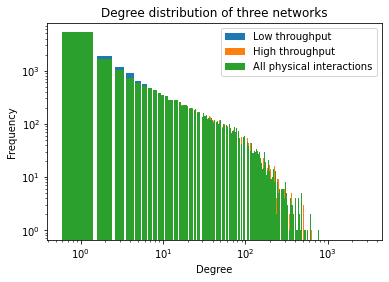

In [191]:
fig, ax = plt.subplots()

p1 = ax.bar(*np.unique(degree_sequence_low, return_counts=True),
            label='Low throughput')
p2 = ax.bar(*np.unique(degree_sequence_high, return_counts=True),
            label='High throughput')
p3 = ax.bar(*np.unique(degree_sequence_phy, return_counts=True),
            label='All physical interactions')

ax.set_ylabel('Frequency')
ax.set_title('Degree distribution of three networks')
ax.set_xlabel('Degree')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()


#fig.tight_layout()
plt.show()

In [210]:
# Since the plot generated above is overlapped, I try separating them and plot in one graph but different subplots to see the distribution of different networks  

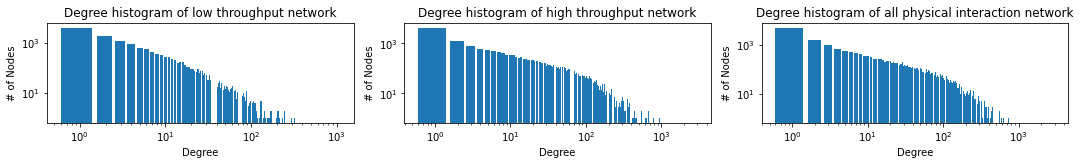

In [209]:

fig = plt.figure("Degree of graphs", figsize=(20, 10))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(15, 4)

ax0 = fig.add_subplot(axgrid[0:3, 0:1])
ax0.bar(*np.unique(degree_sequence_low, return_counts=True),label = 'low')
ax0.set_title("Degree histogram of low throughput network")
ax0.set_xlabel("Degree")
ax0.set_ylabel("# of Nodes")
ax0.set_yscale('log')
ax0.set_xscale('log')


ax1 = fig.add_subplot(axgrid[0:3, 1:2])
ax1.bar(*np.unique(degree_sequence_high, return_counts=True))
ax1.set_title("Degree histogram of high throughput network")
ax1.set_xlabel("Degree")
ax1.set_ylabel("# of Nodes")
ax1.set_yscale('log')
ax1.set_xscale('log')



ax2 = fig.add_subplot(axgrid[0:3, 2:3])
ax2.bar(*np.unique(degree_sequence_phy, return_counts=True))
ax2.set_title("Degree histogram of all physical interaction network")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")
ax2.set_yscale('log')
ax2.set_xscale('log')

plt.tight_layout()
plt.show()

#### Discussion of results
-Q:Are they similar or different? Discuss and provide potential explanations.

-A:

The distribution of these three networks are pretty similar according to both type of the subplots.
First of all, It is probably because all of these three networks are same type of undirected graph and both of the low throughput and high throughput network are the subnetworks of 'all physical interaction' networks.

According to the histrogram, we can jump to another conclusion. That is all of these networks are scale-free networks based on their feature in the plots and also the fewer number of connected components in each network.

## Part 4: further analysis 

In [212]:
# low throughput network
# eigenvector centrality
EC = nx.eigenvector_centrality(G_low)

In [214]:
# degree centrality
DC = nx.degree_centrality(G_low)

In [218]:
PR = nx.pagerank(G_low)

In [220]:
HC = nx.harmonic_centrality(G_low)

In [221]:
# Betweenness centrality
BC = nx.betweenness_centrality(G_low)

In [222]:
# save the dict in file in case rerun the code
save_HC = 'HC_low.txt.'
save_BC = 'BC_low.txt.'
# save dict in file
f1 = open("HC_low.txt","w")
# write file
f1.write( str(HC) )

# close file
f1.close()

In [223]:
f2 = open("BC_low.txt","w")
# write file
f2.write( str(BC) )

# close file
f2.close()

##### Discussion
-Q: Discuss why we choose the harmonic centrality variant of the closeness centrality measure for this particular network.

-A: 
    The reason to choose harmonic centrality variant is because the harmonic centrality algorithm sums the inverse of those distances. This enables it deal with infinite values. In our case, the degree centraility is infinitely small and close to 0, so it is better to use harmonic centrality instead.



### Generate pearson coefficient matrix 

In [255]:
# merge all the calculation of centrality in one dataframe

In [256]:
HC_df = pd.DataFrame({'protein': HC.keys(),
                   'HC': HC.values()})

In [257]:
HC_df.head()

,protein,HC
0,Psma6,3676.830952
1,PVRL2,3603.923810
2,POLR2C,4879.885714
3,RPS23,4871.992857
4,TMED2,3837.265476


In [258]:
DC_df = pd.DataFrame({'protein': DC.keys(),
                   'DC': DC.values()})

In [259]:
BC_df = pd.DataFrame({'protein': BC.keys(),
                   'BC': BC.values()})

In [260]:
PR_df = pd.DataFrame({'protein': PR.keys(),
                   'PR': PR.values()})

In [261]:
EC_df = pd.DataFrame({'protein': EC.keys(),
                   'EC': EC.values()})

In [268]:
dfs = [HC_df, EC_df, DC_df, PR_df,BC_df]
dfs = [df.set_index('protein') for df in dfs]
centrality_df = dfs[0].join(dfs[1:])

In [269]:
centrality_df

,HC,EC,DC,PR,BC
protein,,,,,
Psma6,3676.830952,0.000141,0.000068,0.000017,0.000000e+00
PVRL2,3603.923810,0.000069,0.000136,0.000022,4.886184e-07
POLR2C,4879.885714,0.009449,0.004089,0.000244,5.668990e-04
RPS23,4871.992857,0.007148,0.000681,0.000048,9.179669e-06
TMED2,3837.265476,0.000166,0.000341,0.000036,1.813723e-06
...,...,...,...,...,...
Vps18,3557.042857,0.000051,0.000273,0.000034,2.035374e-06
HERC5,4958.688095,0.010792,0.001772,0.000113,7.103939e-05
DPF3,4712.502381,0.008565,0.002249,0.000154,2.288067e-04


In [275]:
pearson_corr = centrality_df.corr(method='pearson')

In [277]:
pearson_corr

,HC,EC,DC,PR,BC
HC,1.000000,0.582908,0.490868,0.429529,0.265159
EC,0.582908,1.000000,0.923453,0.843327,0.706933
DC,0.490868,0.923453,1.000000,0.964283,0.863621
PR,0.429529,0.843327,0.964283,1.000000,0.896221
BC,0.265159,0.706933,0.863621,0.896221,1.000000


#### comment on pearson coefficient matrix

According to the value in the matrix, eigenvector centrality is highly correlated with degree centrality and Pagerank analysis. Degree centrality is correlated with Pagerank and betweenness centrality. Pagerank value is correlated with betweenness centrality. However, harmonic centrality has poor correlation against any of the other centrality values.

The correlations between measures were also quite varied. The high correlation was between eigenvector centrality and degree (average r=0.92), perhaps because both measures are symmetrized and rely, to some extent, on direct connections. 

Eigenvector centrality is used for undirected graph, while PageRank applies for directed network. However, PageRank uses the indegree as the main measure to estimate the influence level, thus it turns to be a very specific case or variant of Eigenvector centrality. The low throughput network is undirected. So it makes sense if the Pagerank is used for measurement for undirected graph and has high correlation with eigenvector or degree centrality.


Text(0.5, 1.0, 'Correlation between eigenvector centrality and harmonic centrality')

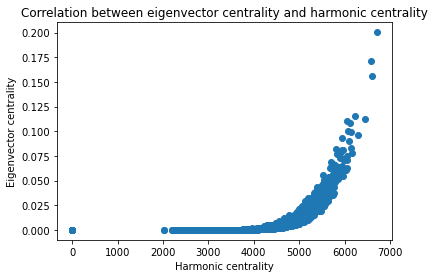

In [288]:
# scatterplot of EC against HC
plt.scatter(centrality_df['HC'].values,centrality_df['EC'].values)
plt.ylabel('Eigenvector centrality')
plt.xlabel('Harmonic centrality')
plt.title('Correlation between eigenvector centrality and harmonic centrality')

#### discussion: leave it for later

### PCA analysis 

In [290]:
from sklearn.preprocessing import StandardScaler

In [294]:
# normalize the dataframe
df_scaled = StandardScaler().fit_transform(centrality_df)
df_scaled[:5]

array([[-0.69760801, -0.41840236, -0.36046434, -0.33513402, -0.14307892],
       [-0.80811224, -0.42791391, -0.32913595, -0.30231594, -0.14269104],
       [ 1.12584357,  0.81217157,  1.48791069,  1.1553326 ,  0.3069439 ],
       [ 1.11388049,  0.50790503, -0.07850883, -0.1347838 , -0.13579181],
       [-0.45443987, -0.41508327, -0.23515078, -0.21129336, -0.14163913]])

In [295]:
# obtain the covariance matrix in Numpy
features = df_scaled.T
cov_matrix = np.cov(features)
cov_matrix[:5]

array([[1.00006814, 0.58294728, 0.49090141, 0.42955805, 0.26517679],
       [0.58294728, 1.00006814, 0.92351548, 0.84338446, 0.70698107],
       [0.49090141, 0.92351548, 1.00006814, 0.96434906, 0.86367955],
       [0.42955805, 0.84338446, 0.96434906, 1.00006814, 0.89628166],
       [0.26517679, 0.70698107, 0.86367955, 0.89628166, 1.00006814]])

In [296]:
# Eigendecomposition is a process that decomposes a square matrix into eigenvectors and eigenvalues.
values, vectors = np.linalg.eig(cov_matrix)
values[:5]

array([3.87772614, 0.81909306, 0.21222485, 0.07364492, 0.01765174])

In [297]:
vectors[:5]

array([[ 0.29538065,  0.87823702,  0.37567919,  0.01524044, -0.00910376],
       [ 0.4733794 ,  0.13274562, -0.69211797,  0.4245313 ,  0.31470054],
       [ 0.50018894, -0.09328831, -0.18537543, -0.23175148, -0.80810613],
       [ 0.48938487, -0.19255891,  0.10508804, -0.68237834,  0.49672912],
       [ 0.44606691, -0.40656696,  0.5782995 ,  0.54789776,  0.03324692]])

In [299]:
# calculate the percentage of explained variance per principal component:
explained_variances = []
for i in range(len(values)):
    explained_variances.append(values[i] / np.sum(values))
 
print(np.sum(explained_variances), '\n', explained_variances)

1.0 
 [0.7754923838944795, 0.1638074499794626, 0.042442077130328035, 0.014727981106545907, 0.003530107889183974]


In [300]:
vectors.T[0]

array([0.29538065, 0.4733794 , 0.50018894, 0.48938487, 0.44606691])

In [306]:
projected_1 = df_scaled.dot(vectors.T[0])
projected_2 = df_scaled.dot(vectors.T[1])
res = pd.DataFrame(projected_1, columns=['PC1'])
res['PC2'] = projected_2
res['protein'] = centrality_df.index
res.head()


,PC1,PC2,protein
0,-0.812256,-0.511875,Psma6
1,-0.817495,-0.619586,PVRL2
2,2.163574,0.610502,POLR2C
3,0.403648,1.134159,RPS23
4,-0.614929,-0.333997,TMED2


### Normalization of the dataframe

In [309]:
#define scaler
scaler = StandardScaler()
#create copy of DataFrame
scaled_df=centrality_df.copy()

In [311]:
# create scaled version of dataframe
scaled_df = pd.DataFrame(scaler.fit_transform(scaled_df), columns=scaled_df.columns)

In [312]:
scaled_df

,HC,EC,DC,PR,BC
0,-0.697608,-0.418402,-0.360464,-0.335134,-0.143079
1,-0.808112,-0.427914,-0.329136,-0.302316,-0.142691
2,1.125844,0.812172,1.487911,1.155333,0.306944
3,1.113880,0.507905,-0.078509,-0.134784,-0.135792
4,-0.454440,-0.415083,-0.235151,-0.211293,-0.141639
...,...,...,...,...,...
14671,-0.879169,-0.430361,-0.266479,-0.225502,-0.141463
14672,1.245283,0.989708,0.422745,0.298211,-0.086686
14673,0.872143,0.695336,0.642044,0.562469,0.038555
14674,-0.519596,-0.410145,-0.297808,-0.284778,-0.141995


### Perform PCA and generate plot 

In [313]:
# perform PCA
from sklearn.decomposition import PCA

#define PCA model to use
pca = PCA(n_components=5)

#fit PCA model to data
pca_fit = pca.fit(scaled_df)

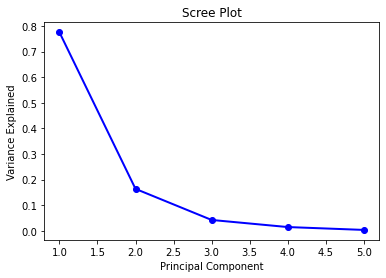

In [315]:
# create scree plot
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [316]:
print(pca.explained_variance_ratio_)

[0.77549238 0.16380745 0.04244208 0.01472798 0.00353011]


#### comment on PCA component - scree plot
The first principal component explains 77.55% of the total variation in the dataset.
The second principal component explains 16.38.74% of the total variation.

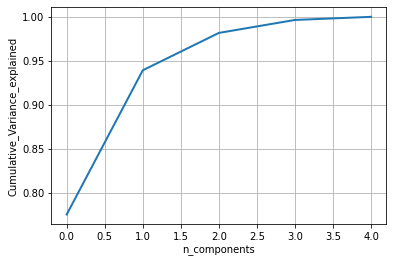

In [317]:
# cumulative scree plot?? or cumulative variance plot
percentage_var_explained = pca.explained_variance_ratio_;  
cum_var_explained=np.cumsum(percentage_var_explained)
#plot PCA spectrum   
plt.figure(1,figsize=(6,4))
plt.clf()  
plt.plot(cum_var_explained,linewidth=2)  
plt.axis('tight')  
plt.grid() 
plt.xlabel('n_components') 
plt.ylabel('Cumulative_Variance_explained')  
plt.show()

In [318]:
cum_var_explained

array([0.77549238, 0.93929983, 0.98174191, 0.99646989, 1.        ])

#### PCA compenent - cumulative variance plot
The first principal component explains 77.55% of the total variation in the dataset.
The second principal component explains 93.92% of the total variation.

In [321]:
pca.explained_variance_ratio_

array([0.77549238, 0.16380745, 0.04244208, 0.01472798, 0.00353011])

### Loadings of PCA

In [322]:
projected_1 = df_scaled.dot(vectors.T[0])
projected_2 = df_scaled.dot(vectors.T[1])
res = pd.DataFrame(projected_1, columns=['PC1'])
res['PC2'] = projected_2
res['protein'] = centrality_df.index
res.head()

,PC1,PC2,protein
0,-0.812256,-0.511875,Psma6
1,-0.817495,-0.619586,PVRL2
2,2.163574,0.610502,POLR2C
3,0.403648,1.134159,RPS23
4,-0.614929,-0.333997,TMED2


#### discussion (d)
have no f**king idea to analyze the result
